In [2]:
#importing the packages for mapping of the datapoints adn categories 

import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import rasterio
from rasterio.plot import show
import mplleaflet
import cartopy.crs as ccrs
import mplcursors
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
categorised_data = pd.read_csv("well_categorization.csv")
categorised_data.head()

,site_id,category,r2_score
0,2.909551e+14,0.0,1.000000
1,2.911361e+14,3.0,0.902742
2,2.925051e+14,0.0,1.000000
3,2.925561e+14,0.0,1.000000
4,2.926181e+14,3.0,0.038265


In [4]:
#convert site_id from scientific notation string to integer
categorised_data['site_id'] = categorised_data['site_id'].astype(float).astype('int64')

In [5]:
categorised_data.head()

,site_id,category,r2_score
0,290955098562101,0.0,1.000000
1,291136099375801,3.0,0.902742
2,292505098254002,0.0,1.000000
3,292556098260701,0.0,1.000000
4,292618099165901,3.0,0.038265


In [6]:
location_data = pd.read_csv("well_location.csv")
location_data.head()

,site_id,agency,latitude,longitude,state,well_depth_va,hole_depth_va
0,272310098160200,USGS,27.386426,-98.267507,TX,310.00,NaN
1,283853097290701,USGS,28.648056,-97.485278,TX,243.00,243.00
2,283939097293201,USGS,28.660833,-97.492222,TX,56.27,56.27
3,290643097575901,USGS,29.111861,-97.966511,TX,132.00,132.00
4,290818098163201,USGS,29.138361,-98.275444,TX,983.00,983.00


In [7]:
#first, check the data types and values
print(location_data['site_id'].dtype)
print(categorised_data['site_id'].dtype)

int64
int64


In [8]:

location_data['site_id'] = location_data['site_id']
categorised_data['site_id'] = categorised_data['site_id']

#merge DataFrames
merged_data = pd.merge(location_data, categorised_data, on='site_id', how='inner')

merged_data.head()

,site_id,agency,latitude,longitude,state,well_depth_va,hole_depth_va,category,r2_score
0,290955098562101,USGS,29.165778,-98.939411,TX,3200.0,3200.0,0.0,1.000000
1,291136099375801,USGS,29.193573,-99.632830,TX,1400.0,1400.0,3.0,0.902742
2,292505098254002,USGS,29.418289,-98.428071,TX,1075.0,1075.0,0.0,1.000000
3,292556098260701,USGS,29.432455,-98.435571,TX,1223.0,1384.0,0.0,1.000000
4,292618099165901,USGS,29.438565,-99.283374,TX,538.0,538.0,3.0,0.038265


In [9]:
#counting wells per state and category
wells_count = merged_data.groupby(['state', 'category']).size().unstack(fill_value=0)



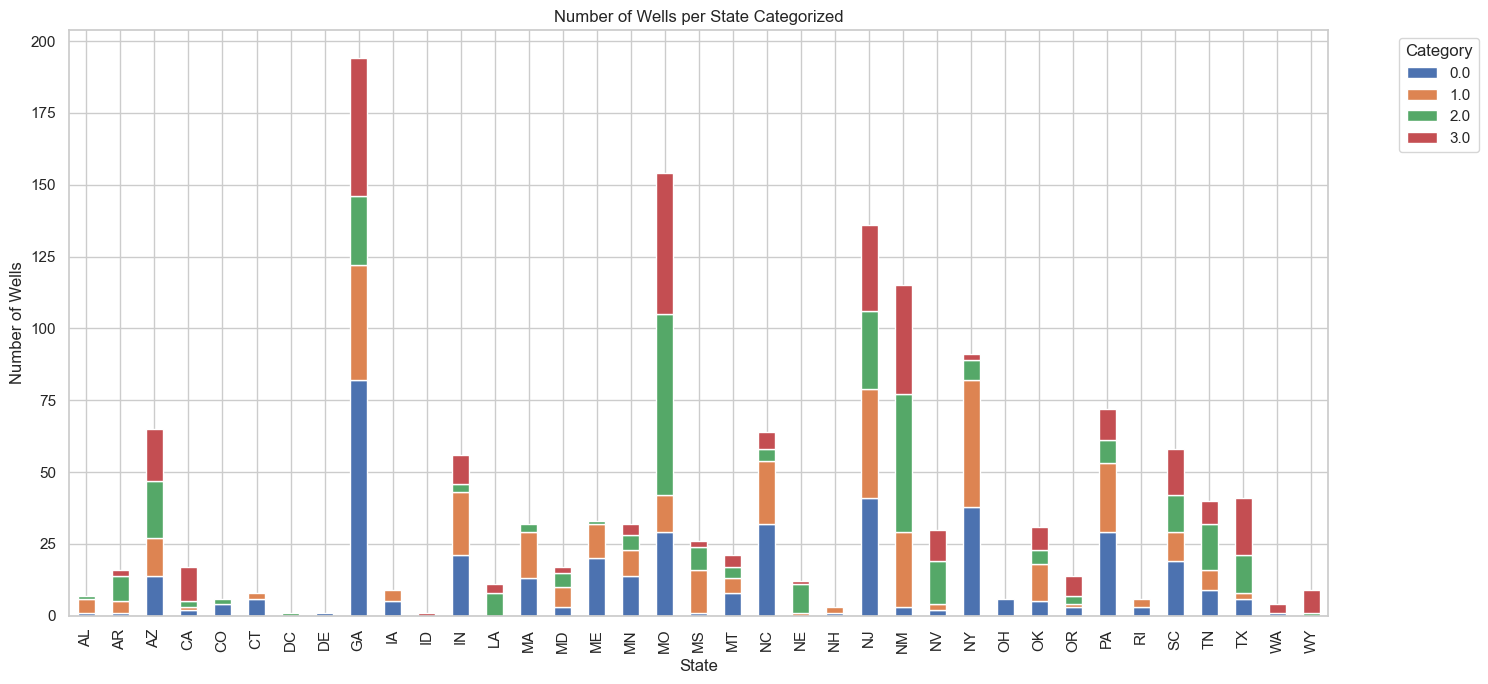

In [10]:

#lets map the number of wells per state divide by category 

#set the aesthetics for the plot
sns.set(style="whitegrid")

#create a bar plot
wells_count.plot(kind='bar', stacked=True, figsize=(15, 7))

#adding labels and title
plt.xlabel('State')
plt.ylabel('Number of Wells')
plt.title('Number of Wells per State Categorized')

#display the legend
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

#show the plot
plt.tight_layout()
plt.show()





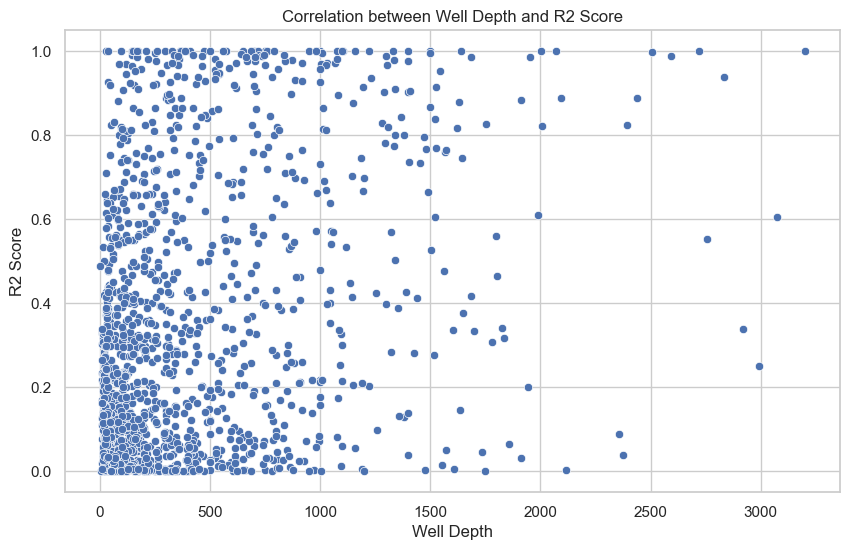

In [11]:
#identify if there's any apparent correlation between the depth of wells and the fit of your linear regression model 
#set the aesthetics for the plot
sns.set(style="whitegrid")

#create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='well_depth_va', y='r2_score', data=merged_data)

#adding labels and title
plt.xlabel('Well Depth')
plt.ylabel('R2 Score')
plt.title('Correlation between Well Depth and R2 Score')

#show the plot
plt.show()


In [12]:
merged_data.head()
merged_data.to_csv("merged_dataset.csv")

In [33]:

# Drop rows with missing values in 'well_depth_va' and 'latitude'
df = merged_data.dropna(subset=['well_depth_va', 'latitude'])

# Plotting the data using Plotly scatter plot
fig = px.scatter(df, x='latitude', y='well_depth_va', color='state',
                 size='well_depth_va', hover_data=['site_id'],
                 labels={'well_depth_va': 'Well Depth', 'latitude': 'Latitude'},
                 title='Well Depth with Respect to Latitude')

# Display the plot
fig.show()


In [14]:

#categories of wells 
# Category 0 - always shallow
# Category 1 - was deep, became shallow
# Category 2 - always deep
# Category 3 - was shallow, now deep


#create scatter map
fig = px.scatter_geo(merged_data, lat='latitude', lon='longitude', color='category',
                     hover_name='well_depth_va', #size='mag',
                     title='Wells around US by Category', scope='usa')
fig.show()

In [27]:
#plot a line plot to compare the well depth and hole depth 

#drop rows with missing values in 'well_depth_va' and 'site_id'
df = merged_data.dropna(subset=['well_depth_va', 'site_id'])
df = merged_data.dropna(subset=['hole_depth_va', 'site_id'])

#plotting the data using Plotly scatter plot
fig = px.scatter(df, x='site_id', y='well_depth_va', size='hole_depth_va',
                 color='state', hover_data=['hole_depth_va'],
                 labels={'well_depth_va': 'Well Depth', 'site_id': 'Site ID', 'hole_depth_va':'Hole Depth'},
                 title='Comparison of Well Depth and Hole Depth by Site ID and State')

fig.show()

In [29]:
#compare the number of wells in different states

#count the number of wells in each state
state_well_counts = merged_data['state'].value_counts().reset_index()
state_well_counts.columns = ['state', 'well_count']

#plotting the data using Plotly choropleth map
fig = px.choropleth(state_well_counts, 
                    locations='state', 
                    locationmode='USA-states',
                    color='well_count',
                    color_continuous_scale='Viridis',
                    scope='usa',
                    labels={'well_count': 'Number of Wells'},
                    title='Number of Wells by State in the U.S.')

#display the plot
fig.show()